In [1]:
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv("cifar10_final.csv", header = None)

In [3]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,3063,3064,3065,3066,3067,3068,3069,3070,3071,3072
0,26,17,13,13,13,14,14,15,14,10,...,237,144,33,29,46,28,27,26,27,0
1,94,101,95,94,94,97,111,142,166,154,...,145,147,150,152,163,174,182,184,155,0
2,183,158,166,167,169,171,163,163,160,161,...,174,177,227,250,250,250,250,250,250,1
3,255,254,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,0
4,182,156,156,144,118,132,148,118,136,85,...,83,83,75,79,72,68,73,67,75,0


In [5]:
X = df.iloc[:, 0:-1].to_numpy()
Y = df.iloc[:, -1].to_numpy()
X = X / 256.0

In [4]:
import timeit
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim import Optimizer

In [6]:
EPOCHS = 100
BATCH_SIZE = 64
LEARNING_RATE = 0.001

In [7]:
class TrainData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_data = TrainData(torch.FloatTensor(X), torch.FloatTensor(Y))

In [8]:
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)

In [10]:
class BinaryClassification(nn.Module):
    def __init__(self):
        super(BinaryClassification, self).__init__()
        # Number of input features is 3072.
        self.layer_1 = nn.Linear(3072, 128) 
        self.layer_2 = nn.Linear(128, 64)
        self.layer_out = nn.Linear(64, 1)
        self.relu = nn.ReLU()
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.relu(self.layer_2(x))
        x = self.layer_out(x)
        
        return x

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [12]:
class SGD_Simple(Optimizer):
    
    def __init__(self, params, lr, weight_decay=0.0):
        
        if lr < 0.0:
            raise ValueError("Invalid learning rate: {}".format(lr))
            
        defaults = dict(lr=lr, weight_decay=weight_decay)
        
        super(SGD_Simple, self).__init__(params, defaults)

    def step(self):

        for group in self.param_groups:
            weight_decay = group['weight_decay']

            for p in group['params']:
                if p.grad is None:
                    continue
                d_p = p.grad.data
                if weight_decay != 0:
                    d_p.add_(weight_decay, p.data)
                    
                p.data.add_(-group['lr'], d_p)

In [13]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [14]:
model = BinaryClassification()
model.to(device)
print(model)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
# optimizer = SGD_Simple(model.parameters(), lr = 0.002)

BinaryClassification(
  (layer_1): Linear(in_features=3072, out_features=128, bias=True)
  (layer_2): Linear(in_features=128, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
)


In [15]:
timelist = []
losslist = []
acclist = []

start_time = timeit.default_timer()

model.train()
for e in range(1, 200+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        
        y_pred = model(X_batch)
        
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        acc = binary_acc(y_pred, y_batch.unsqueeze(1))
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        epoch_time = timeit.default_timer()

    print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')
    losslist.append(epoch_loss/len(train_loader))
    timelist.append(epoch_time - start_time)
    acclist.append(epoch_acc/len(train_loader))

Epoch 001: | Loss: 0.28235 | Acc: 90.651
Epoch 002: | Loss: 0.25632 | Acc: 91.114
Epoch 003: | Loss: 0.24415 | Acc: 91.398
Epoch 004: | Loss: 0.23475 | Acc: 91.522
Epoch 005: | Loss: 0.23028 | Acc: 91.607
Epoch 006: | Loss: 0.22944 | Acc: 91.663
Epoch 007: | Loss: 0.22504 | Acc: 91.776
Epoch 008: | Loss: 0.22005 | Acc: 91.940
Epoch 009: | Loss: 0.21796 | Acc: 91.985
Epoch 010: | Loss: 0.21559 | Acc: 91.952
Epoch 011: | Loss: 0.21277 | Acc: 92.150
Epoch 012: | Loss: 0.21081 | Acc: 92.186
Epoch 013: | Loss: 0.20858 | Acc: 92.247
Epoch 014: | Loss: 0.20656 | Acc: 92.268
Epoch 015: | Loss: 0.20413 | Acc: 92.545
Epoch 016: | Loss: 0.20228 | Acc: 92.486
Epoch 017: | Loss: 0.20053 | Acc: 92.583
Epoch 018: | Loss: 0.19941 | Acc: 92.505
Epoch 019: | Loss: 0.19960 | Acc: 92.545
Epoch 020: | Loss: 0.19685 | Acc: 92.620
Epoch 021: | Loss: 0.19506 | Acc: 92.636
Epoch 022: | Loss: 0.19454 | Acc: 92.754
Epoch 023: | Loss: 0.19230 | Acc: 92.745
Epoch 024: | Loss: 0.19136 | Acc: 92.805
Epoch 025: | Los

In [16]:
model = BinaryClassification()
model.to(device)
print(model)
criterion = nn.BCEWithLogitsLoss()
# optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
optimizer2 = SGD_Simple(model.parameters(), lr = 0.003)

BinaryClassification(
  (layer_1): Linear(in_features=3072, out_features=128, bias=True)
  (layer_2): Linear(in_features=128, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
)


In [17]:
timelist3 = []
losslist3 = []
acclist3 = []

start_time = timeit.default_timer()

model.train()
for e in range(1, 200+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer2.zero_grad()
        
        y_pred = model(X_batch)
        
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        acc = binary_acc(y_pred, y_batch.unsqueeze(1))
        
        loss.backward()
        optimizer2.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        epoch_time = timeit.default_timer()

    print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')
    losslist3.append(epoch_loss/len(train_loader))
    timelist3.append(epoch_time - start_time)
    acclist3.append(epoch_acc/len(train_loader))

<ipython-input-12-aaa8c161f6b5>:24: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755898319/work/torch/csrc/utils/python_arg_parser.cpp:1055.)
  p.data.add_(-group['lr'], d_p)


Epoch 001: | Loss: 0.37386 | Acc: 90.088
Epoch 002: | Loss: 0.33261 | Acc: 90.077
Epoch 003: | Loss: 0.30476 | Acc: 90.079
Epoch 004: | Loss: 0.28932 | Acc: 90.072
Epoch 005: | Loss: 0.28164 | Acc: 90.132
Epoch 006: | Loss: 0.27659 | Acc: 90.382
Epoch 007: | Loss: 0.27196 | Acc: 90.623
Epoch 008: | Loss: 0.26809 | Acc: 90.728
Epoch 009: | Loss: 0.26433 | Acc: 90.836
Epoch 010: | Loss: 0.26096 | Acc: 90.937
Epoch 011: | Loss: 0.25766 | Acc: 91.010
Epoch 012: | Loss: 0.25493 | Acc: 91.087
Epoch 013: | Loss: 0.25205 | Acc: 91.142
Epoch 014: | Loss: 0.24928 | Acc: 91.247
Epoch 015: | Loss: 0.24752 | Acc: 91.221
Epoch 016: | Loss: 0.24498 | Acc: 91.305
Epoch 017: | Loss: 0.24304 | Acc: 91.374
Epoch 018: | Loss: 0.24102 | Acc: 91.495
Epoch 019: | Loss: 0.23933 | Acc: 91.531
Epoch 020: | Loss: 0.23749 | Acc: 91.555
Epoch 021: | Loss: 0.23605 | Acc: 91.659
Epoch 022: | Loss: 0.23464 | Acc: 91.652
Epoch 023: | Loss: 0.23347 | Acc: 91.684
Epoch 024: | Loss: 0.23188 | Acc: 91.689
Epoch 025: | Los

In [18]:
def group_product(xs, ys):
    
    return sum([torch.sum(x * y) for (x, y) in zip(xs, ys)])

def normalization(v):
    # normalize a vector
    
    s = group_product(v, v)
    s = s**0.5
    s = s.cpu().item()
    v = [vi / (s + 1e-6) for vi in v]
    return v

In [19]:
class NysHessianpartial():
    
    def __init__(self, rank, rho):
        self.rank = rank
        # rho is the regularization in Nystrom sketch
        self.rho = rho
    
    def get_params_grad(self, model):
        # get parameters and differentiation
        params = []
        grads = []
        for param in model.parameters():
            if not param.requires_grad:
                continue
            params.append(param)
            grads.append(0. if param.grad is None else param.grad + 0.)
        return params, grads
    
    def update_Hessian(self, X_batch, y_batch, model, criterion, device):
        
        shift = 0.001
        # get the model parameters and gradients
        params, gradsH = self.get_params_grad(model)
        # remember the size for each group of parameters
        self.size_vec = [p.size() for p in params]
        # store random gaussian vector to a matrix
        test_matrix = []
        # Hessian vector product
        hv_matrix = []
        
        for i in range(self.rank):
            # generate gaussian random vector
            v = [torch.randn(p.size()).to(device) for p in params]
            # normalize
            v = normalization(v)
            # zero vector to store the shape
            hv_add = [torch.zeros(p.size()).to(device) for p in params]
        
            # update hessian with a subsample batch
            
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            model.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch.unsqueeze(1))
            loss.backward(create_graph=True)
            params, gradsH = self.get_params_grad(model)
            # calculate the Hessian vector product
            hv = torch.autograd.grad(gradsH, params, grad_outputs=v,only_inputs=True,retain_graph=True)
            # add initial shift
            for i in range(len(hv)):
                hv_add[i].data = hv[i].data.add_(hv_add[i].data)    
                hv_add[i].data = hv_add[i].data.add_(v[i].data * torch.tensor(shift)) 
            
            # reshape the Hessian vector product into a long vector
            hv_ex = torch.cat([gi.view(-1) for gi in hv_add])
            # reshape the random vector into a long vector
            test_ex = torch.cat([gi.view(-1) for gi in v])
            
            # append long vectors into a large matrix
            hv_matrix.append(hv_ex)
            test_matrix.append(test_ex)
        
        # assemble the large matrix
        hv_matrix_ex = torch.column_stack(hv_matrix)
        test_matrix_ex = torch.column_stack(test_matrix)
        # calculate Omega^T * A * Omega for Cholesky
        choleskytarget = torch.mm(test_matrix_ex.t(), hv_matrix_ex)
        # perform Cholesky, if fails, do eigendecomposition
        # the new shift is the abs of smallest eigenvalue (negative) plus the original shift
        try:
            C_ex = torch.linalg.cholesky(choleskytarget)
        except:
            # eigendecomposition, eigenvalues and eigenvector matrix
            eigs, eigvectors = torch.linalg.eigh(choleskytarget)
            shift = shift + torch.abs(torch.min(eigs))
            # add shift to eigenvalues
            eigs = eigs + shift
            # put back the matrix for Cholesky by eigenvector * eigenvalues after shift * eigenvector^T 
            C_ex = torch.linalg.cholesky(torch.mm(eigvectors, torch.mm(torch.diag(eigs), eigvectors.T)))
        
        # triangular solve
        B_ex = torch.linalg.solve_triangular(C_ex, hv_matrix_ex, upper = False, left = False)
        # SVD
        U, S, V = torch.linalg.svd(B_ex, full_matrices = False)
        self.U = U
        self.S = torch.max(torch.square(S) - torch.tensor(shift), torch.tensor(0.0))
        

In [20]:
class NysHessianOpt(Optimizer):
    r"""Implements NysHessian.
    Args:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float): learning rate
        rank (int): sketch rank
        rho: regularization
    """
    def __init__(self, params, lr, rank = 100, rho = 0.5):
        if lr < 0.0:
            raise ValueError("Invalid learning rate: {}".format(lr))
        # initialize the optimizer    
        defaults = dict(lr=lr, rank = rank, rho = rho)
        self.nysh = NysHessianpartial(rank, rho)
        super(NysHessianOpt, self).__init__(params, defaults)
         
    def step(self):
        # one step update
        for group in self.param_groups:
            rho = group['rho']
            # compute gradient as a long vector
            g = torch.cat([p.grad.view(-1) for p in group['params']])
            # calculate the search direction by Nystrom sketch and solve
            UTg = torch.mv(self.nysh.U.t(), g) 
            g_new = torch.mv(self.nysh.U, (self.nysh.S + rho).reciprocal() * UTg) + g / rho - torch.mv(self.nysh.U, UTg) / rho            
            ls = 0
            # update model parameters
            for p in group['params']:
                gp = g_new[ls:ls+torch.numel(p)].view(p.shape)
                ls += torch.numel(p)
                p.data.add_(-group['lr'] * gp)

In [21]:
model = BinaryClassification()
model.to(device)
print(model)
criterion = nn.BCEWithLogitsLoss()
# optimizer = optim.Adam(model.parameters(), lr = 0.003)
optimizer = NysHessianOpt(model.parameters(), lr = 0.003)

BinaryClassification(
  (layer_1): Linear(in_features=3072, out_features=128, bias=True)
  (layer_2): Linear(in_features=128, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
)


In [24]:
hes_interval = 700
# update Hessian and Nystrom sketch every couple of steps
hes_iter = 0


timelist2 = []
losslist2 = []
acclist2 = []

start_time = timeit.default_timer()

model.train()
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    
    for X_batch, y_batch in train_loader:
        
        if hes_iter % hes_interval == 0:
            # update Hessian and sketch
            optimizer.nysh.update_Hessian(X_batch, y_batch, model, criterion, device)
        
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        
        y_pred = model(X_batch)
        
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        acc = binary_acc(y_pred, y_batch.unsqueeze(1))
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        hes_iter += 1
        epoch_time = timeit.default_timer()

    print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')
    losslist2.append(epoch_loss/len(train_loader))
    timelist2.append(epoch_time - start_time)
    acclist2.append(epoch_acc/len(train_loader))

<ipython-input-19-3030989fd95c>:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.S = torch.max(torch.square(S) - torch.tensor(shift), torch.tensor(0.0))


Epoch 001: | Loss: 0.19186 | Acc: 92.947
Epoch 002: | Loss: 0.19037 | Acc: 92.967
Epoch 003: | Loss: 0.18875 | Acc: 92.996
Epoch 004: | Loss: 0.18781 | Acc: 93.068
Epoch 005: | Loss: 0.18634 | Acc: 93.130
Epoch 006: | Loss: 0.18483 | Acc: 93.199
Epoch 007: | Loss: 0.18278 | Acc: 93.245
Epoch 008: | Loss: 0.18156 | Acc: 93.342
Epoch 009: | Loss: 0.17971 | Acc: 93.377
Epoch 010: | Loss: 0.17895 | Acc: 93.307
Epoch 011: | Loss: 0.17723 | Acc: 93.430
Epoch 012: | Loss: 0.17544 | Acc: 93.483
Epoch 013: | Loss: 0.17501 | Acc: 93.495
Epoch 014: | Loss: 0.17346 | Acc: 93.494
Epoch 015: | Loss: 0.17166 | Acc: 93.628
Epoch 016: | Loss: 0.16964 | Acc: 93.664
Epoch 017: | Loss: 0.16860 | Acc: 93.666
Epoch 018: | Loss: 0.16665 | Acc: 93.793
Epoch 019: | Loss: 0.16534 | Acc: 93.791
Epoch 020: | Loss: 0.16367 | Acc: 93.883
Epoch 021: | Loss: 0.16311 | Acc: 94.006
Epoch 022: | Loss: 0.16058 | Acc: 93.962
Epoch 023: | Loss: 0.15943 | Acc: 94.076
Epoch 024: | Loss: 0.15849 | Acc: 93.994
Epoch 025: | Los

KeyboardInterrupt: 

In [25]:
class NysHessianPSGD(Optimizer):
    r"""Implements NysHessian.
    Args:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float): learning rate
        rank (int): sketch rank
        rho: regularization
    """
    def __init__(self, params, lr, rank = 100, rho = 0.5):
        if lr < 0.0:
            raise ValueError("Invalid learning rate: {}".format(lr))
        # initialize the optimizer    
        defaults = dict(lr=lr, rank = rank, rho = rho)
        self.nysh = NysHessianpartial(rank, rho)
        super(NysHessianPSGD, self).__init__(params, defaults)
         
    def step(self):
        # one step update
        for group in self.param_groups:
            rho = group['rho']
            # compute gradient as a long vector
            g = torch.cat([p.grad.view(-1) for p in group['params']])
            # calculate the search direction by Nystrom preconditioned gradient descent
            UTg = torch.mv(self.nysh.U.t(), g) 
            g_new = torch.mv(self.nysh.U, (self.nysh.S + rho).reciprocal() * UTg) * (torch.min(self.nysh.S) + rho) + g - torch.mv(self.nysh.U, UTg)            
            ls = 0
            # update model parameters
            for p in group['params']:
                gp = g_new[ls:ls+torch.numel(p)].view(p.shape)
                ls += torch.numel(p)
                p.data.add_(-group['lr'] * gp)

In [26]:
model = BinaryClassification()
model.to(device)
print(model)
criterion = nn.BCEWithLogitsLoss()
# optimizer = optim.Adam(model.parameters(), lr = 0.003)
optimizer = NysHessianPSGD(model.parameters(), lr = 0.003)

BinaryClassification(
  (layer_1): Linear(in_features=3072, out_features=128, bias=True)
  (layer_2): Linear(in_features=128, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
)


In [27]:
hes_interval = 700
# update Hessian and Nystrom sketch every couple of steps
hes_iter = 0

timelist4 = []
losslist4 = []
acclist4 = []

start_time = timeit.default_timer()

model.train()
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    
    for X_batch, y_batch in train_loader:
        
        if hes_iter % hes_interval == 0:
            # update Hessian and sketch
            optimizer.nysh.update_Hessian(X_batch, y_batch, model, criterion, device)
        
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        
        y_pred = model(X_batch)
        
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        acc = binary_acc(y_pred, y_batch.unsqueeze(1))
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        hes_iter += 1
        epoch_time = timeit.default_timer()

    print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')
    losslist4.append(epoch_loss/len(train_loader))
    timelist4.append(epoch_time - start_time)
    acclist4.append(epoch_acc/len(train_loader))

<ipython-input-19-3030989fd95c>:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.S = torch.max(torch.square(S) - torch.tensor(shift), torch.tensor(0.0))


Epoch 001: | Loss: 0.37053 | Acc: 90.092
Epoch 002: | Loss: 0.32298 | Acc: 90.087
Epoch 003: | Loss: 0.29947 | Acc: 90.082
Epoch 004: | Loss: 0.28764 | Acc: 90.077
Epoch 005: | Loss: 0.28150 | Acc: 90.189
Epoch 006: | Loss: 0.27675 | Acc: 90.350
Epoch 007: | Loss: 0.27258 | Acc: 90.499
Epoch 008: | Loss: 0.26857 | Acc: 90.683
Epoch 009: | Loss: 0.26479 | Acc: 90.810
Epoch 010: | Loss: 0.26138 | Acc: 90.909
Epoch 011: | Loss: 0.25814 | Acc: 90.981
Epoch 012: | Loss: 0.25517 | Acc: 91.030
Epoch 013: | Loss: 0.25238 | Acc: 91.144
Epoch 014: | Loss: 0.24973 | Acc: 91.205
Epoch 015: | Loss: 0.24720 | Acc: 91.258
Epoch 016: | Loss: 0.24481 | Acc: 91.324
Epoch 017: | Loss: 0.24236 | Acc: 91.403
Epoch 018: | Loss: 0.24033 | Acc: 91.442
Epoch 019: | Loss: 0.23815 | Acc: 91.486
Epoch 020: | Loss: 0.23594 | Acc: 91.601
Epoch 021: | Loss: 0.23389 | Acc: 91.630
Epoch 022: | Loss: 0.23186 | Acc: 91.719
Epoch 023: | Loss: 0.22989 | Acc: 91.774
Epoch 024: | Loss: 0.22791 | Acc: 91.845
Epoch 025: | Los

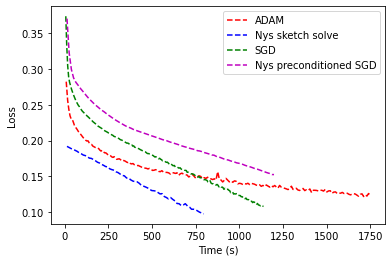

In [32]:
plt.ylabel("Loss")
plt.xlabel("Time (s)")
plt.plot(timelist, losslist, 'r--', timelist2, losslist2, 'b--', timelist3, losslist3, 'g--', timelist4, losslist4, 'm--')
plt.legend(["ADAM", "Nys sketch solve", "SGD", "Nys preconditioned SGD"])
plt.show()

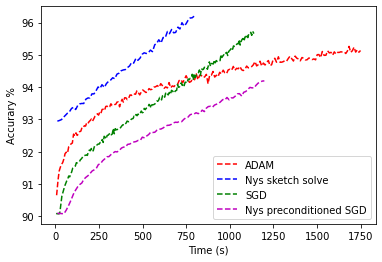

In [33]:
plt.ylabel("Accurary %")
plt.xlabel("Time (s)")
plt.plot(timelist, acclist, 'r--', timelist2, acclist2, 'b--', timelist3, acclist3, 'g--', timelist4, acclist4, 'm--')
plt.legend(["ADAM", "Nys sketch solve", "SGD", "Nys preconditioned SGD"])
plt.show()

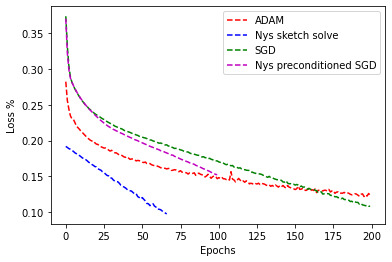

In [34]:
plt.ylabel("Loss %")
plt.xlabel("Epochs")
plt.plot(losslist, 'r--', losslist2, 'b--', losslist3, 'g--', losslist4, 'm--')
plt.legend(["ADAM", "Nys sketch solve", "SGD", "Nys preconditioned SGD"])
plt.show()

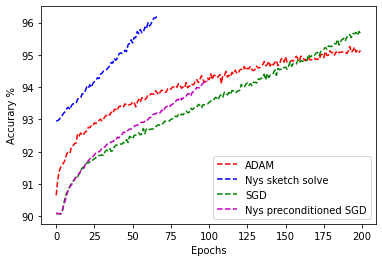

In [35]:
plt.ylabel("Accurary %")
plt.xlabel("Epochs")
plt.plot(acclist, 'r--', acclist2, 'b--', acclist3, 'g--', acclist4, 'm--')
plt.legend(["ADAM", "Nys sketch solve", "SGD", "Nys preconditioned SGD"])
plt.show()

In [ ]:

# try update hessian sketch, using the same batch as gradient
# then try update hessian sketch, using the previous one batch as gradient
# 
